1. [Load data bundle](#Load-data-bundle)

1. [Feature's Engineering](#Feature's-Engineering)
        
1. [Trading Algorithm with ML Models](#Trading-Algorithm-with-ML-Models)
    1. [ML Models Design](#ML-Models-Design)
    1. [Plug-in Best Model implementation into Trading Bot](#Plug-in-Best-Model-implementation-into-Trading-Bot)
    1. [Backtest ML Trading Strategy](#Backtest-ML-Trading-Strategy)

## Import Libraries

In [7]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [9]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
%watermark --iversions

seaborn 0.9.0
zipline 1.4.0
pandas  0.22.0
numpy   1.14.2



# Load data bundle
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

More details on data bundle ingesting and loading in Zipline can be found in the Jupyter Notebook <code>eda_quandl.ipynb</code>.

In [11]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

In [12]:
bundle_data = bundles.load('quandl')

In [13]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


In [14]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [15]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [16]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

In [17]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [53]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7115,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [54]:
df.head()

,Equity(8 [AAPL])
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


In [55]:
df.index = pd.DatetimeIndex(df.index)

In [56]:
df['close'] = df[list(df.columns)[0]]

In [57]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-01-02 00:00:00+00:00,35.25
1990-01-03 00:00:00+00:00,38.00
1990-01-04 00:00:00+00:00,38.25
1990-01-05 00:00:00+00:00,37.75
1990-01-08 00:00:00+00:00,37.50


# Feature's Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<b>Alpha factors</b><br>

Algorithmic trading strategies are driven by signals that trigger buy and sell asset orders aiming at generating superior returns relative to a benchmark (such as an index). The part of an asset's return that is not explained by exposure to this benchmark is called alpha, and hence the signals producing such uncorrelated returns are also called alpha factors. <br>

More concretely, alpha factors are transformations of raw market, fundamental or alternative data, that aim to predict asset price movements. They are designed to capture risks that drive asset returns. Every time the trading strategy evaluates the factor, it obtains a signal.<br>

In theory, risk factors should be independent of each other, but more often than not, they appear to be correlated. For this reason, it is adviced to consider one or more factors in trading. The most common ones in trading are momentum and sentiment factors and fundamental (or value) factors.

Zipline provides many built-in factors from a broad range of data sources, that can be combined with other Python libraries (Numpy, Pandas, Ta-Lib) to derive more complex factors.<br>

<b>Technical Analysis and ML Trading Strategy</b><br>

However, for this particular project, we shall devise two trading strategies (ML and signals) based on technical analysis and disregard other factors explaining asset returns. Since our <i>Buy and Hold</i> trading strategies will rely on the following logic:<br>
<ul>
    <li> if the maximum forecast value is higher than the mean historical values, then we buy X shares of the asset</li>
    <li> if the maximum forecast value is lower than the mean historical values, then we sell X shares of the asset</li>
</ul>

we shall, for the ML trading strategy, create 40 simple returns' new variables, and for each point in time, we shall train 32 values and predict the remaining 8 ones. This converts our problem into a <i>multi-target regression</i>, which we shall address conveniently in further steps.

## Factor's preprocessing

In [58]:
df['1d'] = df.shift(-1)

In [59]:
for d in range(2, 41):
    col = '%dd'% d
    df[col] = df['close'].shift(-1 * d)

In [60]:
df = df.dropna()

In [61]:
for i in reversed(range(2, 41)):
    col = '%dd' % i
    prev = '%dd' % (i - 1)
    df[col] = (df[col] - df[prev]) / df[prev]

In [62]:
df['1d'] = (df['1d'] - df['close']) / df['close']

In [63]:
df = df.drop(columns=['close'])

In [64]:
df.tail()

,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d,31d,32d,33d,34d,35d,36d,37d,38d,39d,40d
2018-01-23 00:00:00+00:00,-0.000282,-0.015487,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141
2018-01-24 00:00:00+00:00,-0.015487,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793
2018-01-25 00:00:00+00:00,-0.014355,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471
2018-01-26 00:00:00+00:00,-0.010698,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471,-0.001900
2018-01-29 00:00:00+00:00,-0.027239,0.008126,0.001768,-0.006969,-0.041566,-0.026838,0.053317,-0.017138,-0.020089,0.009104,0.021767,0.006761,0.041369,0.015136,-0.001799,0.004534,-0.005960,0.010885,0.015432,0.015594,0.000893,-0.004017,-0.032150,0.013947,0.015410,-0.016694,0.003087,0.014133,0.013093,0.012757,-0.012432,-0.010093,0.000840,-0.007445,-0.011730,-0.001141,-0.028793,-0.009471,-0.001900,0.033379


Let's now split the series between features and targets.

In [65]:
# Create features (X) and targets (y)
X = df.iloc[:,:32]
y = df.iloc[:,32:]

In [66]:
X.shape

(6993, 32)

In [69]:
y.shape

(6993, 8)

# Trading Algorithm with ML Models
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<b>Ensemble Model</b><br>
Ensembling is a method for combining base models and is based on the hypothesis that a much more powerful model can be produced by combining multiple models together. There are different types of ensemble modelling:<br>
<ul>
    <li><b>Bagging</b>: short for bootstrap aggregation, uses bootstrap sampling to obtain data subsets for training 'base learners' and reduces variance. The most common algorithm is Random Forest, the process of generation is parallel and the base learner output in regression is averaging,</li>
    <li><b>Boosting</b>: converts 'weak learners' to strong learners and reduces bias. The most common algorithm is AdaBoost, the process of generation is sequential and the base learner output in regression is weighted sum,</li>
    <li><b>Stacking</b>: combines multiple models via a meta-model and improves predictions</li>
</ul>
In this section, we will only tackle the first two methods, since <code>scikit-learn</code> library's version in the Zipline environment is 0.20.0 (on Py35 compatibility grounds) and the stacking method was only introduced in release 0.22.0 (see link herebelow). No package version 0.22 or higher compatible with py35 has been found neither in conda main or alternative channels (check the following cell). <code>conda update</code> also fails to update the package to a newer version.

<code>scikit-learn</code>'s [release 0.22.0](https://scikit-learn.org/stable/auto_examples/release_highlights/plot_release_highlights_0_22_0.html)

In [3]:
!conda search -c anaconda scikit-learn=0.22=py35* --info

Loading channels: done
No match found for: scikit-learn==0.22[build=py35*]. Search: *scikit-learn*==0.22[build=py35*]

PackagesNotFoundError: The following packages are not available from current channels:

  - scikit-learn==0.22[build=py35*]

Current channels:

  - https://conda.anaconda.org/anaconda/linux-64
  - https://conda.anaconda.org/anaconda/noarch
  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




<b>Neural Networks and Zipline</b><br>
<code>Keras</code> and <code>Tensorflow</code> are not supported in local Zipline research environment. Though having installed both, a message error is displayed when importing them. It appears that, to date, no satisfactory and technically feasible solutions have been found to port the DL algorithm into the Zipline local platform. For that reason, and regrettably enough, deep learning models cannot be performed in this project but will be explored in the future.<br>

Particularly, Long-Short Term Memory (LSTM) and Echo State Networks (ESN) models, falling under the family of  Recurrent Neural Networks, seem to work fine with financial time series, since they are able to capture non-linear relationships among variables and correct for vanishing gradient descents.

<b>Step-by-step approach</b><br>
In this section, we shall:
<ol>
    <li>build a baseline model</li>
    <li>assess the performance of other models</li>
    <li>create a model's pipeline for hyperparameter tuning and model's evaluation:</li>
    <ol>
        <li><code>get_model()</code>: this function will create a dictionary of models to be evaluated</li>
        <li><code>evaluate_model()</code>: this function will evaluate each of the models</li>
        <li><code>best_model()</code>: this function will return the best model after creating a model pipeline and performing hyperparameter tuning</li>
    </ol> 
    <li>export best model's results in a joblib format</li>
</ol>

### Import Libraries

In [67]:
# Sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Regressors
import sklearn.linear_model as LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.multioutput import MultiOutputRegressor


# Data Scaling (for KNN-neighbours)
from sklearn.preprocessing import scale

# Hyperparameter tuning
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# Metrics
from sklearn.metrics import r2_score

### Train, Test, Split

Considering that financial times series are not independently and identically distibuted, on grounds of serial autocorrelation and time-varying standard deviation, we shall use TimeSeriesSplit object from sklearn to allow for incremental cross validation.

In [68]:
tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(643, 32) (643, 8)
(635, 32) (635, 8)
(1278, 32) (1278, 8)
(635, 32) (635, 8)
(1913, 32) (1913, 8)
(635, 32) (635, 8)
(2548, 32) (2548, 8)
(635, 32) (635, 8)
(3183, 32) (3183, 8)
(635, 32) (635, 8)
(3818, 32) (3818, 8)
(635, 32) (635, 8)
(4453, 32) (4453, 8)
(635, 32) (635, 8)
(5088, 32) (5088, 8)
(635, 32) (635, 8)
(5723, 32) (5723, 8)
(635, 32) (635, 8)
(6358, 32) (6358, 8)
(635, 32) (635, 8)


## ML Models Design
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### 1. Baseline Model

We shall use the scoring metric MAE, mean absolute value, negated so as to uniform sklearn handling <br>
 
 <blocquote>MSE = $\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}$</blocquote> <br>
 
 the closer to zero values, the better

#### Dummy Regressor

In [96]:
# Evaluate naive

# Instantiate a DummyRegressor with 'median' strategy
naive = DummyRegressor(strategy='mean')

# Fit the model
naive.fit(X_train, y_train)

# Make predictions
naive_pred = naive.predict(X_test)

# Make predictions
naive_train_pred = naive.predict(X_train)
naive_test_pred = naive.predict(X_test)

# Print scores
print(naive.score(X_train, y_train))
print(naive.score(X_test, y_test))

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator, n_jobs=-1, and error_score set to 'raise'
n_scores = cross_val_score(naive, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of n_scores:
print('Baseline: mean (%.3f), std (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

5.133756931314619e-16
-0.00029733960149634804
1.0
Baseline: mean (-0.001), std (0.001)


We shall have this dummy regressor as baseline, and we will try to improve from here.

### 2. Other ML Models

#### Support Vector Machine

In [97]:
# Evaluate baseline model

# Instantiate a Support Vector Regressor with 'rbf' kernel, gamma set to 'scale', and regularization parameter set to 10
svr = SVR(kernel='rbf',gamma='scale',C=10)

# Pass a MultiOutputRegressor to model
svr = MultiOutputRegressor(svr)

# Fit the model
svr.fit(X_train, y_train)

# Make predictions
svr_pred = svr.predict(X_test)

# Make predictions
svr_train_pred = svr.predict(X_train)
svr_test_pred = svr.predict(X_test)

# Print scores
print(svr.score(X_train, y_train))
print(svr.score(X_test, y_test))

# Calculate accuracy using `cross_val_score()` with model instantiated, data to fit, target variable, 'neg_mean_absolute_error' scoring, cross validator 'cv', n_jobs=-1, and error_score set to 'raise'
svr_scores = cross_val_score(svr, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')

# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(svr_scores), np.std(svr_scores)))

-0.366443845127447
-0.7935657381876741
Good: -0.002 (0.001)


#### Decision Trees

R^2 train: 0.0209, R^2 test: -0.2667


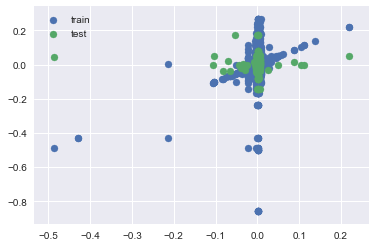

Negative mean squared error: -0.0011 (0.0006)


In [76]:
# Let's use max_depth = 5 to fit again our DT model
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)

# Predict values from train and test
dt_train_pred = dt.predict(X_train)
dt_test_pred = dt.predict(X_test)

# Score on train/test sets
score_train = r2_score(y_train, dt_train_pred)
score_test = r2_score(y_test, dt_test_pred)
print('R^2 train: %.4f, R^2 test: %.4f' % (score_train, score_test))

# Scatter prediction vs actual values
plt.scatter(dt_train_pred, y_train, label='train')
plt.scatter(dt_test_pred, y_test, label='test')
plt.legend()
plt.show()

# Print mean and standard deviation of m_scores: 
dt_scores = cross_val_score(dt, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
print('Negative mean squared error: %.4f (%.4f)' % (np.mean(dt_scores), np.std(dt_scores)))


Although the error term is quite low, the Goodness of fit $R^2$ is not good neither in train nor in test pointing to a model misspecification.


#### Random Forest

In [77]:
# First, create an Instance
rfr = RandomForestRegressor()

# Second, create a dictionnary of hyperparameters to search
grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Third, loop over the parameter grid, set the hyperparameters and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g) # unpack the dictionnary
    rfr.fit(X_train, y_train)
    test_scores.append(rfr.score(X_test, y_test))
    
# Fourth, find best hyperparameters
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.00019230625539703124 {'random_state': 42, 'n_estimators': 100, 'max_features': 8, 'max_depth': 5}


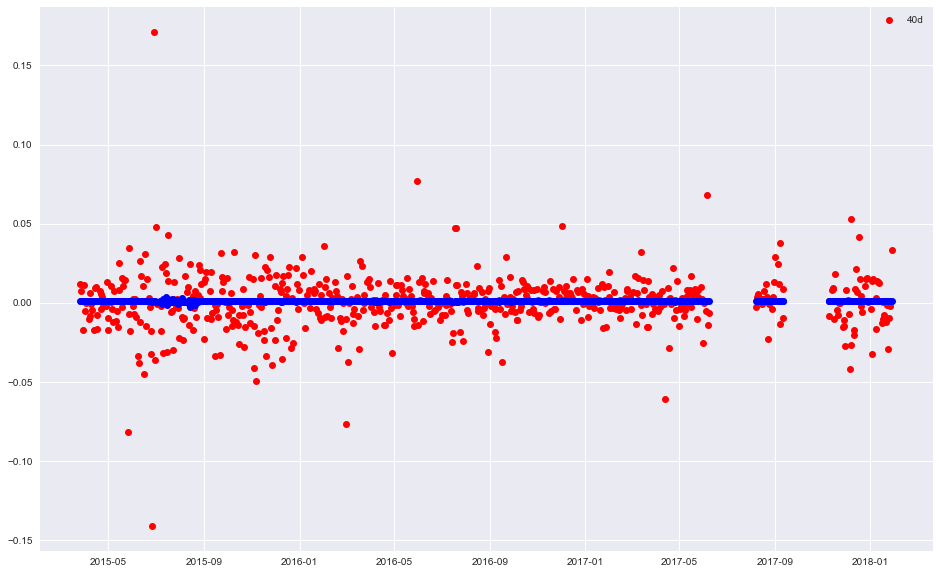

0.038476011457767655
0.00019230625539703124


In [88]:
# Instantiate the model
rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = 8, random_state = 42)

# Fit the model
rfr.fit(X_train, y_train)

# Make predictions
train_pred_rfr = rfr.predict(X_train)
test_pred_rfr = rfr.predict(X_test)

# Create a scatter plot with train and test actual vs predictions
plt.figure(figsize=(16,10))

plt.plot(y_test.index, y_test['40d'], 'ro')
plt.plot(y_test.index, test_pred_rfr[:,7], 'bo')
plt.legend()
plt.show()

# Print scores
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

In [79]:
# Negative mean squared error
m_scores = cross_val_score(rfr, X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
print('Good: %.3f (%.3f)' % (np.mean(m_scores), np.std(m_scores)))

Good: -0.001 (0.001)


#### Gradient Boosting Trees

In [95]:
# Create GB model -- hyperparameters (to be tuned!!)
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)

# For multiple target predictions, we shall use MultiOutputRegressor
gbr = MultiOutputRegressor(gbr)

# Fit the model
gbr.fit(X_train, y_train)

# Make predictions
train_pred_gbr = gbr.predict(X_train)
test_pred_gbr = gbr.predict(X_test)

# Print scores
print(gbr.score(X_train, y_train))
print(gbr.score(X_test, y_test))

0.07563548925157097
-0.007474131207838436


In [90]:
cross_validate(gbr, X, y=y, cv=tscv, scoring='neg_mean_squared_error')

{'fit_time': array([0.88302708, 1.14535308, 1.44119501, 1.76971173, 2.1481986 ,
        2.56074452, 2.87274194, 3.53271008, 3.57071018, 3.9655602 ]),
 'score_time': array([0.01435184, 0.01517463, 0.01584911, 0.01607251, 0.01272964,
        0.01204133, 0.01280379, 0.0109899 , 0.0104332 , 0.01012945]),
 'test_score': array([-0.00093989, -0.00116107, -0.00148825, -0.0022743 , -0.00100386,
        -0.00058777, -0.00095038, -0.00033781, -0.00146699, -0.00030813]),
 'train_score': array([-0.00066468, -0.0007575 , -0.00085825, -0.00100481, -0.00120102,
        -0.00114661, -0.00106929, -0.0010576 , -0.00097912, -0.00101937])}

In [94]:
def plotme(y_test, test_pred_gbr, col, step):
    plt.figure(figsize=(16,10))

    plt.plot(y_test.index, y_test[col], 'ro')
    plt.plot(y_test.index, test_pred_gbr[:,step], 'bo')

    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.legend()
    plt.show();

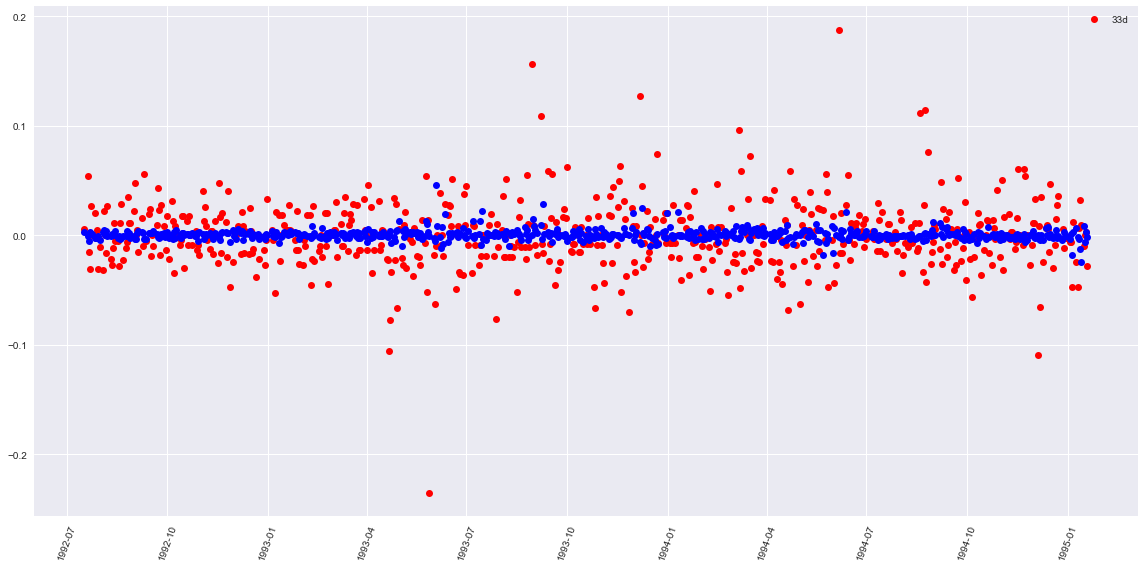

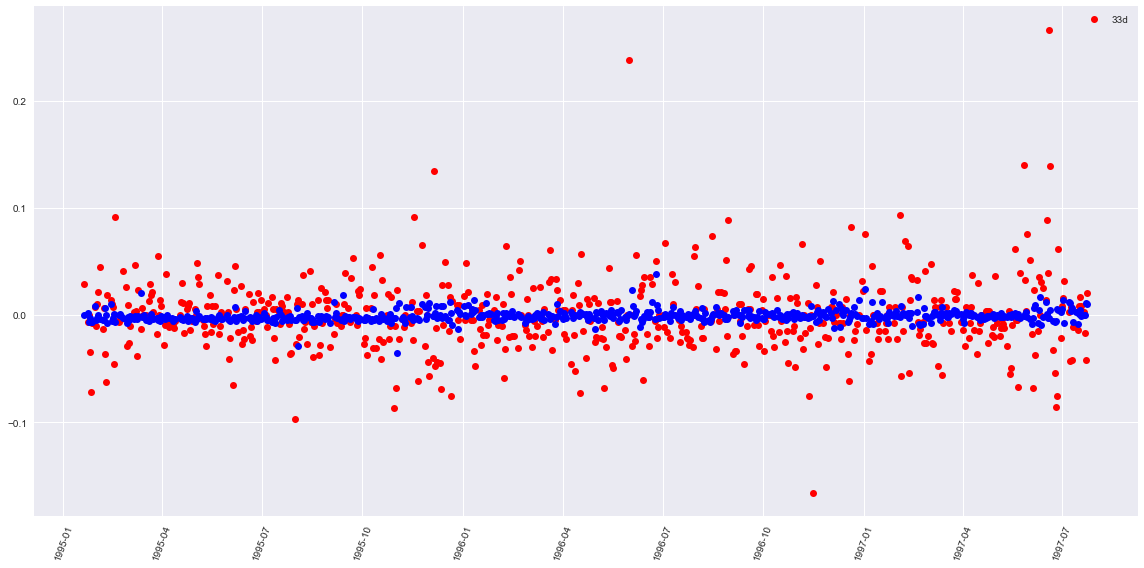

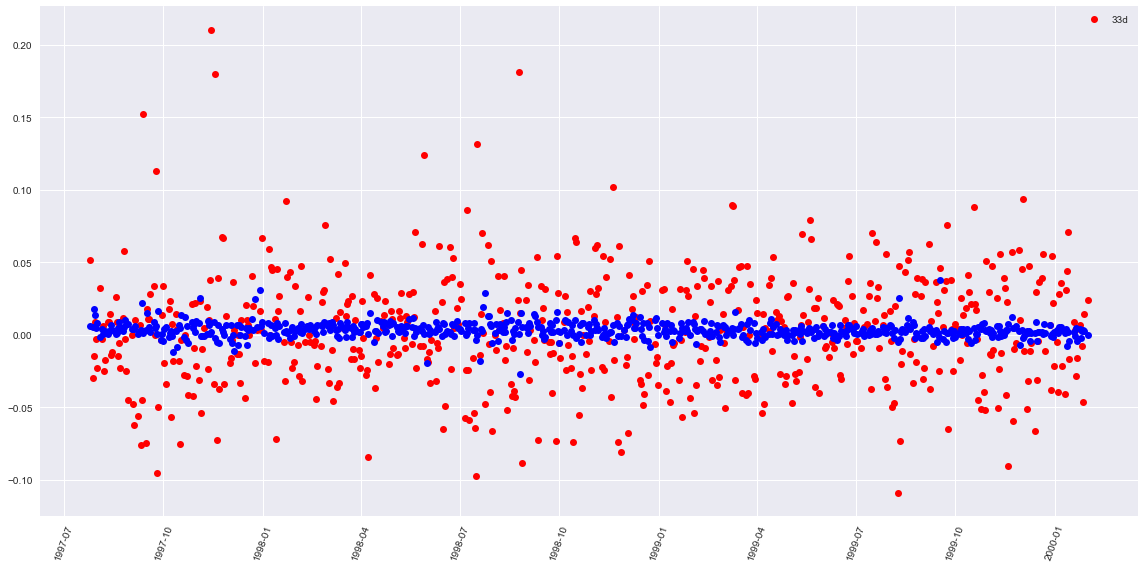

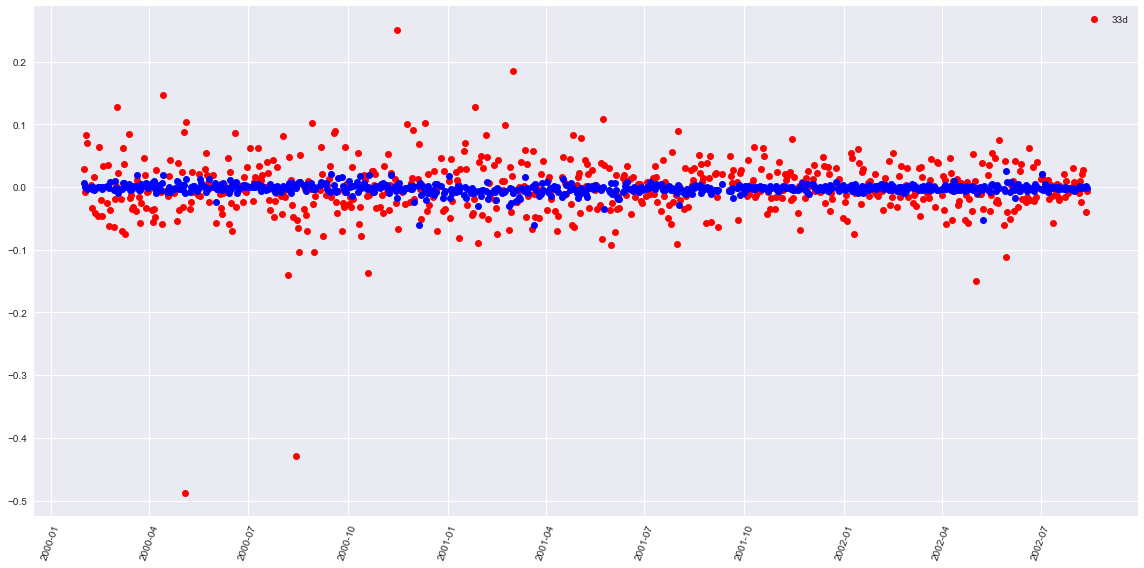

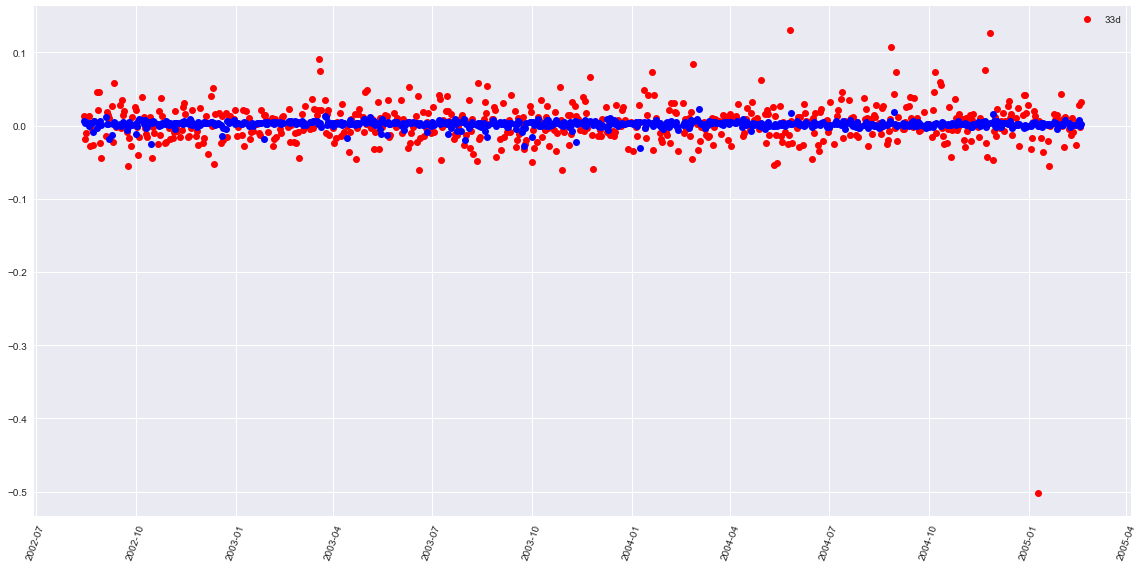

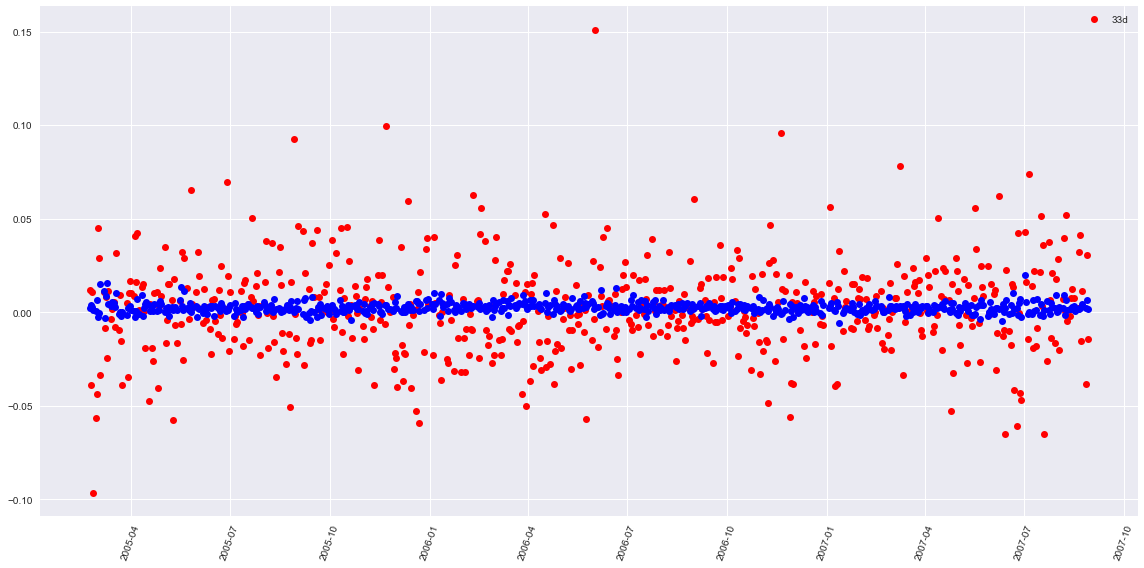

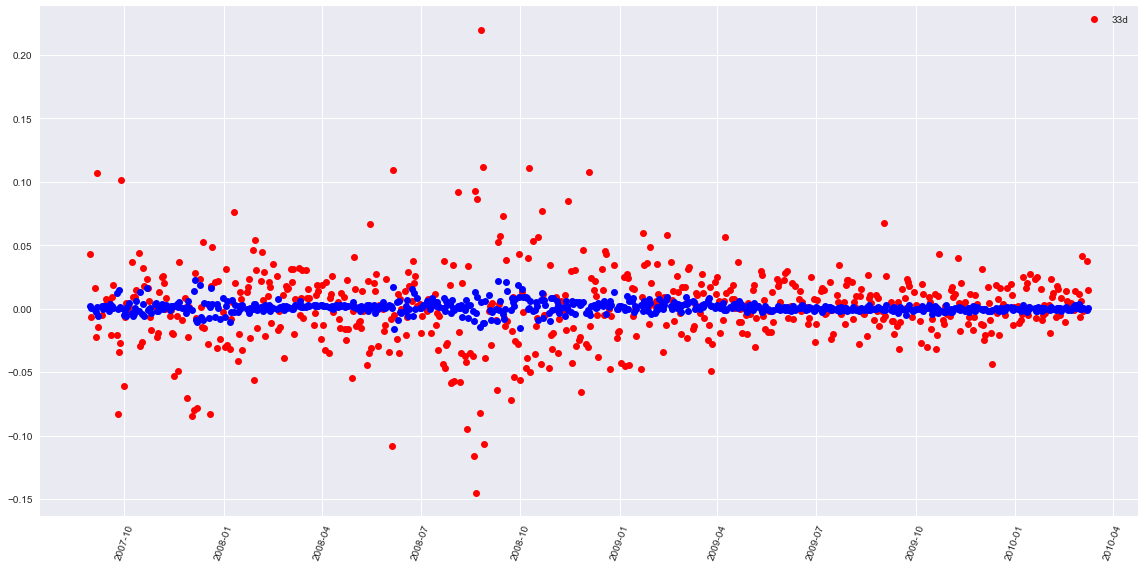

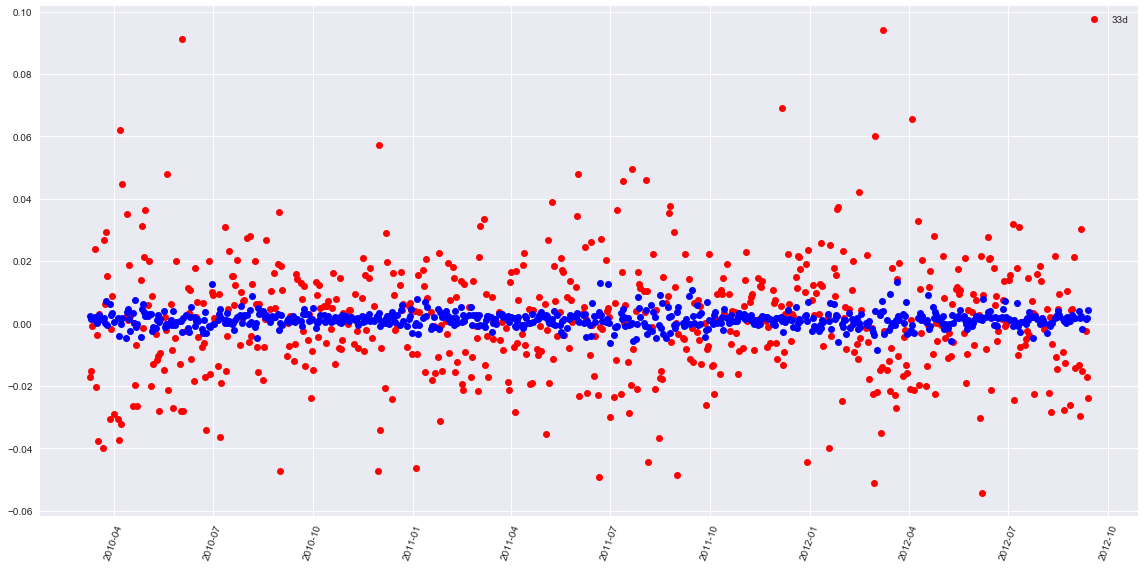

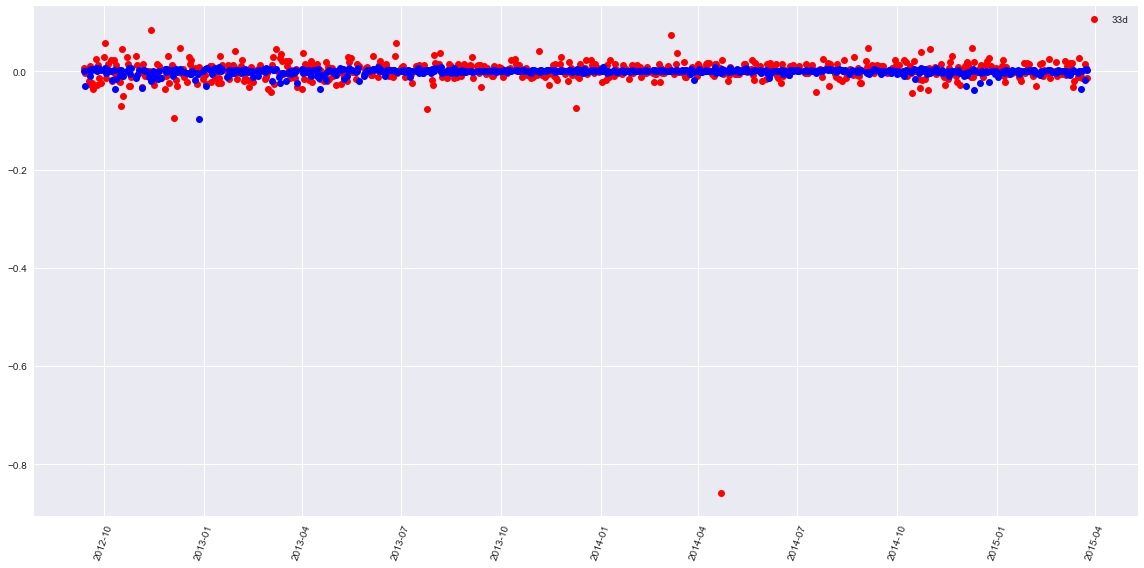

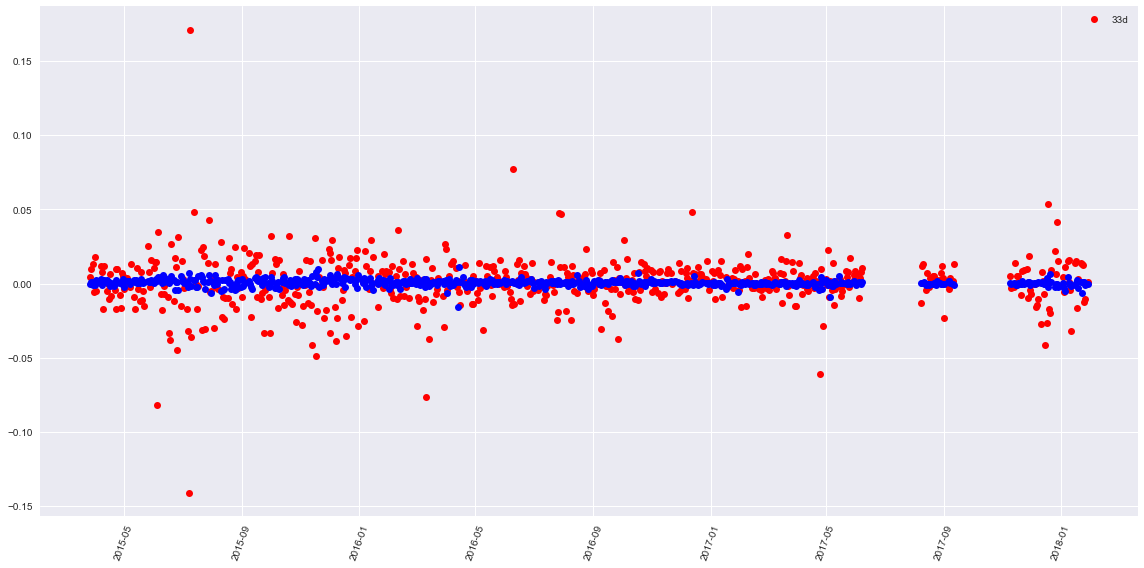

In [93]:
from sklearn.model_selection import cross_val_predict

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    test_pred_gbr = cross_val_predict(gbr, X_test, y=y_test)
    plotme(y_test, test_pred_gbr, '33d', 0)

#### K-Neighbors

Some models, like K-nearest neighbors (KNN), work better with scaled data -- so we'll standardize our data. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.<br>
Sklearn's <code>scale()</code> will standardize data, which sets the mean to 0 and standard deviation to 1.

In [99]:
# Standardize the train and test features
scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)
scaled_X = scale(X)

In [100]:
# Create and fit the KNN model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_X_train, y_train)

# Make predictions
knn_pred = naive.predict(scaled_X_test)

# Make predictions
knn_train_pred = knn.predict(scaled_X_train)
knn_test_pred = knn.predict(scaled_X_test)

# Print scores
print(knn.score(scaled_X_train, y_train))
print(knn.score(scaled_X_test, y_test))
 
# Second, create a dictionnary of hyperparameters to search
knn_scores = cross_val_score(knn, scaled_X, y, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, error_score='raise')
    
# Print mean and standard deviation of m_scores: 
print('Good: %.3f (%.3f)' % (np.mean(knn_scores), np.std(knn_scores)))


0.196877733594022
-0.6891917966096704
Good: -0.001 (0.001)


-3.051755878782225
-1.4617462672012067


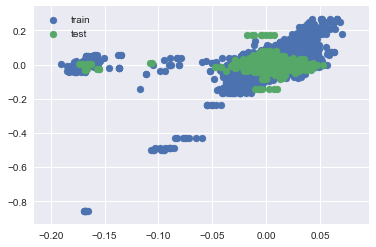

In [101]:
# Plot the actual vs predicted values
plt.scatter(knn_train_pred, y_train, label='train')
plt.scatter(knn_test_pred, y_test, label='test')
plt.legend()

print(r2_score(knn_train_pred, y_train))
print(r2_score(knn_test_pred, y_test))


### Create Custom Functions

#### A. Models' Dictionnary

#### B. Models' Evaluation

#### C. Best Model Selection

### 4. Export best model in a joblib format

In [29]:
# Export trained models and save it for future predictions
from joblib import dump
dump(best_regressor, '../strategies/models/best_regressor.joblib')

['../strategies/models/rfr_regressor.joblib']

## Plug-in Best Model implementation into Trading Bot
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

We modify the <code>buy_and_hold.py</code> Python script (strategies folder) to account for, ceteris paribus:
<ul>
    <li>lagged and forecast values</li>
    <li>under the <code>initialize </code>function, load our RF regressor joblib </li>
    <li>under the <code>handle_data</code> function:<br>
        <ol>
        <li>create one array with lagged 32 values for each point in time and  one array with 8 forecast values, and</li>
        <li>code the strategy: if the max predictive value is above the mean of historical/past values, then we place a buy order and viceversa</li>
        </ol>
    

The portfolio value has reached a value of round 228 million EUR, whereas the classic strategy BuyAndHold recorded a value of round 561.100 EUR.

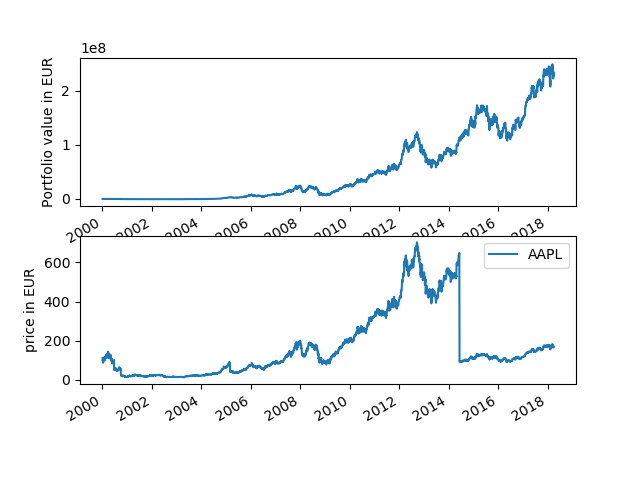

## Backtest ML Trading Strategy
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [35]:
df = pd.read_csv('../reports/buy_and_hold.csv')

In [36]:
df = df.rename(columns={'Unnamed: 0':'date'}).set_index('date')

<Figure size 1296x576 with 0 Axes>

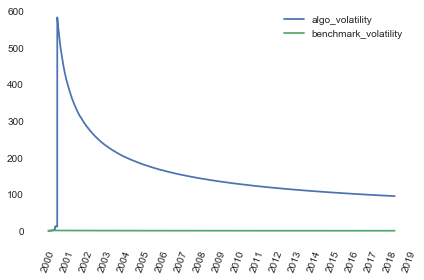

In [48]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algo_volatility)
ax.plot(df.index, df.benchmark_volatility)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

<Figure size 1296x576 with 0 Axes>

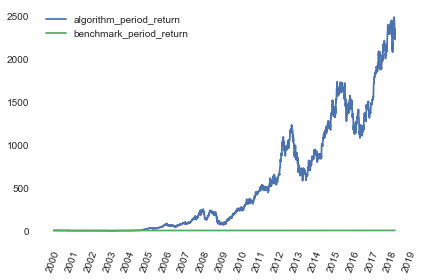

In [49]:
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, date2num, DateFormatter

plt.figure(figsize = (18, 8))

df.index = pd.DatetimeIndex(df.index)

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.3)

# Create a plot
ax.plot(df.index, df.algorithm_period_return)
ax.plot(df.index, df.benchmark_period_return)

lctr = YearLocator()
frmt = DateFormatter('%Y')

# Final formatting
ax.xaxis.set_major_locator(lctr)
ax.xaxis.set_major_formatter(frmt)

plt.xticks(rotation=70)
plt.tight_layout()

plt.legend()
plt.show()

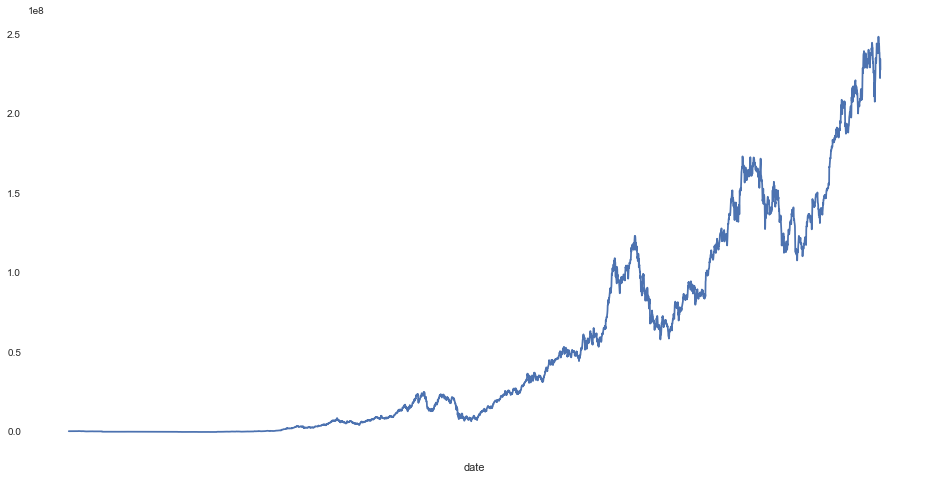

In [37]:
df.portfolio_value.plot(figsize=(16,8))

In [38]:
'${:.2f}'.format(df.capital_used.sum())

'$-33730147.25'

In [39]:
'${:.2f}'.format(df.portfolio_value[-1])

'$227667200.75'

In [40]:
'${:.2f}'.format(df.capital_used.sum() + df.portfolio_value[-1])

'$193937053.51'